# ML Pipeline

## Data Preparation

In [80]:
from utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [60]:
credentials_path = 'datascience-capstone-project-05b1642f45c3.json'

In [61]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/refined/base_dataset.csv"
base_dataset =  pd.read_csv(path, index_col=0)
df = base_dataset.copy()

In [62]:
df.head()

,Papel,Tipo,Empresa,Setor,Subsetor,dy_label,cotacao_rel,cotacao_mean_median_ratio,cotacao_std,cotacao_spread,...,Div_Bruta,Div_Liquida,Receita_Liquida_12m,EBIT_12m,Receita_Liquida_3m,EBIT_3m,papel,year,date,Data_ult_cot_year
0,AGRO3,ON NM,BRASILAGRO ON NM,Agropecuária,Agricultura,0.0460,1.662407,0.985848,2.624917,0.606310,...,670359000.0,178850000.0,1.700870e+09,556112000.0,3.149470e+08,12157000.0,AGRO3,2019.0,2019-01-02,2023.0
0,AGRO3,ON NM,BRASILAGRO ON NM,Agropecuária,Agricultura,0.0794,2.002730,1.100418,4.416940,0.698352,...,670359000.0,178850000.0,1.700870e+09,556112000.0,3.149470e+08,12157000.0,AGRO3,2021.0,2021-02-27,2023.0
0,AGRO3,ON NM,BRASILAGRO ON NM,Agropecuária,Agricultura,0.2208,2.580469,1.086475,7.631578,1.039925,...,670359000.0,178850000.0,1.700870e+09,556112000.0,3.149470e+08,12157000.0,AGRO3,2022.0,2022-03-14,2023.0
0,ALPA3,ON N1,ALPARGATAS ON N1,"Tecidos, Vestuário e Calçados",Calçados,0.0203,0.103111,1.850696,59.692898,2.277847,...,381066000.0,140082000.0,3.967490e+09,609389000.0,1.089930e+09,161888000.0,ALPA3,2013.0,2013-01-05,2023.0
0,ALPA3,ON N1,ALPARGATAS ON N1,"Tecidos, Vestuário e Calçados",Calçados,0.0342,0.254021,2.684391,43.798022,2.998497,...,381066000.0,140082000.0,3.967490e+09,609389000.0,1.089930e+09,161888000.0,ALPA3,2014.0,2014-01-08,2023.0


#### Defining Label

In [63]:
df.isna().sum().sort_values(ascending=False)

Papel                  0
liqc                   0
roe                    0
roe_rel                0
roe_median             0
                      ..
pcg_spread_rel_past    0
pebit                  0
pebit_rel              0
pebit_median           0
Data_ult_cot_year      0
Length: 184, dtype: int64

#### Adjust data types

In [64]:
df.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'dy_label',
       'cotacao_rel', 'cotacao_mean_median_ratio', 'cotacao_std',
       'cotacao_spread',
       ...
       'Div_Bruta', 'Div_Liquida', 'Receita_Liquida_12m', 'EBIT_12m',
       'Receita_Liquida_3m', 'EBIT_3m', 'papel', 'year', 'date',
       'Data_ult_cot_year'],
      dtype='object', length=184)

#### Numerical encoding for object variables

In [65]:
features_to_drop = ['Data_ult_cot','papel','date','Data_ult_cot_year','year']
df.drop(features_to_drop, axis=1, inplace=True)

In [66]:
df_objects = df.select_dtypes('object').copy()
df_objects = df_objects.drop(['Empresa','Papel'], axis=1)
object_cols = df_objects.columns
print(object_cols)

Index(['Tipo', 'Setor', 'Subsetor'], dtype='object')


In [67]:
for col in object_cols:
    df[col] = df_objects[col].astype('category').cat.codes

df.dtypes

Papel                   object
Tipo                      int8
Empresa                 object
Setor                     int8
Subsetor                  int8
                        ...   
Div_Liquida            float64
Receita_Liquida_12m    float64
EBIT_12m               float64
Receita_Liquida_3m     float64
EBIT_3m                float64
Length: 179, dtype: object

#### Spliting data into training a test data

In [68]:
X.max().sort_values(ascending=False)

Receita_Liquida_12m    6.168670e+11
patrliq                3.607000e+11
patrliq_median         3.348585e+11
patrliq_mean           3.266123e+11
Div_Bruta              2.934030e+11
                           ...     
roic_mean              6.538167e-01
roic_median            6.519000e-01
c5y_mean               5.993000e-01
roic_std               1.964759e-01
dy_median              1.313000e-01
Length: 145, dtype: float64

features X_train: 176
features X_test: 176
XGBoost cross val score: 0.23366304709585
test score: -0.008727368476230568 
train score: 0.9998487316444951


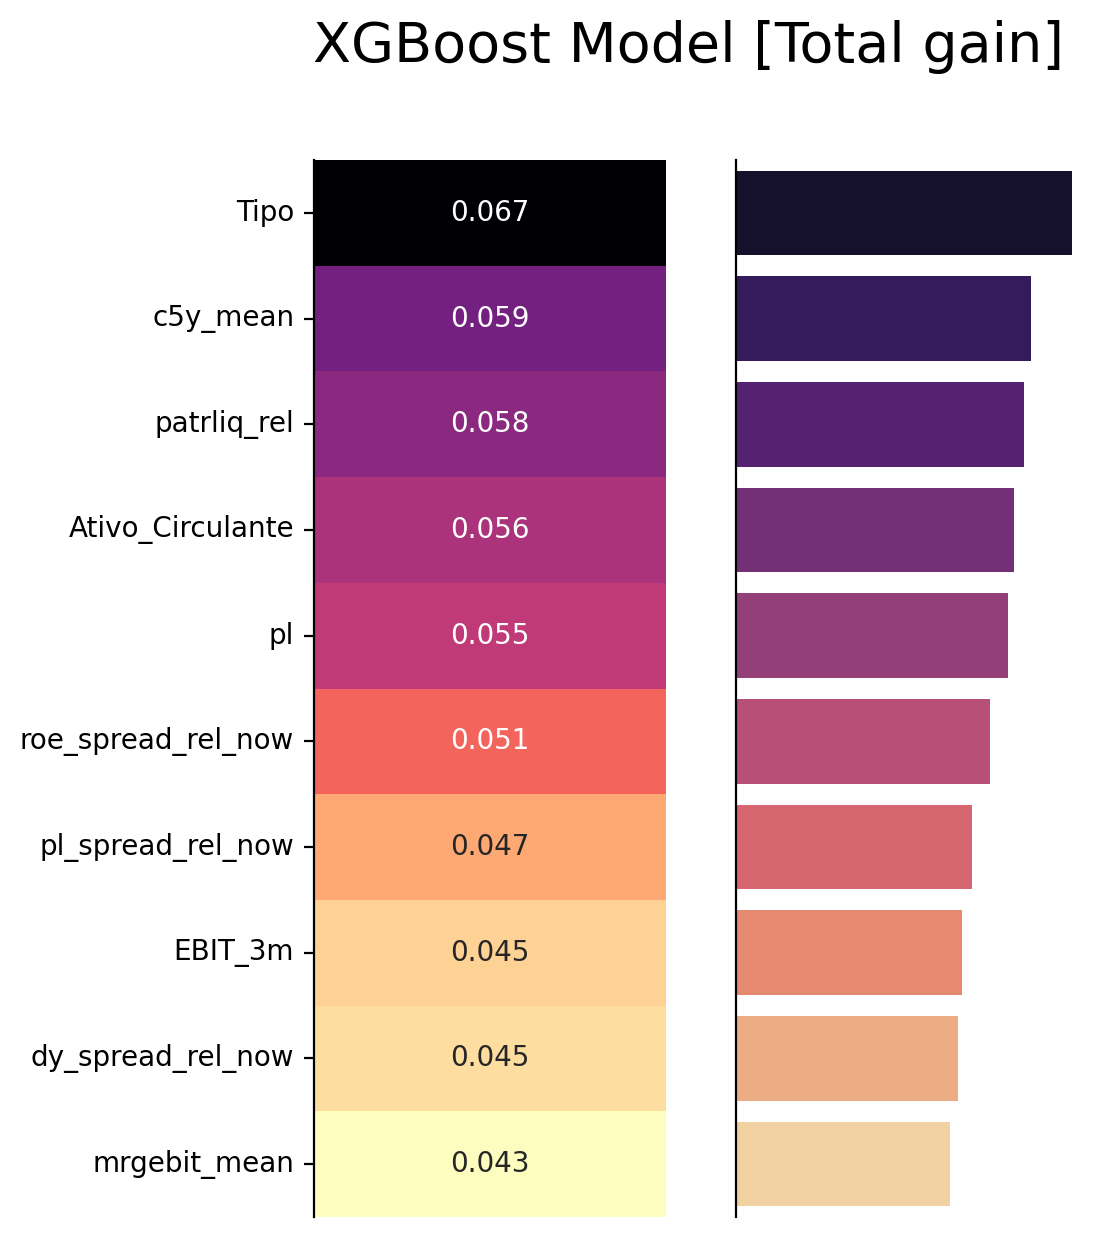

In [82]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['Papel','Empresa','dy_label'], axis=1)
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# Learning - XGBoost
xgbc = XGBRegressor()
xgbc.fit(X_train, y_train)
xgbc_pred_train=xgbc.predict(X_train)
xgbc_pred_test=xgbc.predict(X_test)

# performing crossvalidation test 
xgscore = np.mean(cross_val_score(estimator=xgbc,
                       X=X_train, y=y_train, cv=5))
# printing cross validation results
print(f'XGBoost cross val score: {xgscore}')

# analysing train and test data results
train_score_xgbc =  r2_score(y_train, xgbc_pred_train)
test_score_xgbc = r2_score(y_test, xgbc_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgbc} \ntrain score: {train_score_xgbc}')

# getting the most important features
dict_importance = xgbc.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

In [83]:
most_important_XGBoost_review.iloc[:25]

,Total gain
Tipo,0.067419
c5y_mean,0.059169
patrliq_rel,0.057734
Ativo_Circulante,0.055811
pl,0.054637
roe_spread_rel_now,0.050924
pl_spread_rel_now,0.047346
EBIT_3m,0.045274
dy_spread_rel_now,0.044603
mrgebit_mean,0.042880


### Building a Machine Learning Pipeline 

In [70]:
def build_pipelines(regressors):
    pipelines = {}
    for algorithm,regressor in regressors.items():
        pipeline = Pipeline([
            ('reg',regressor)
        ])
        pipelines[algorithm] = pipeline

    return pipelines

In [71]:

def build_models(classifiers,parameters_dict):
    pipelines = build_pipelines(classifiers)

    cvs = {}
    
    for algorithm,parameters in parameters_dict.items():
        # create grid search object
        cv = GridSearchCV(pipelines[algorithm], param_grid=parameters)
        cvs[algorithm] = cv
    
    return cvs

In [72]:
def display_and_store_results(cv,y_test,y_pred,algorithm):
    
    columns = y_test.columns
    classification_reports = []
    for i, col in enumerate(columns):
        print(col)
        classif_report = classification_report(y_test[col], y_pred[:,i])
        print(classif_report)
        classification_reports.append(classif_report)
        print('___________________________________')
        
    print("\nBest Parameters:", cv.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':cv.best_params_,
        'class':classification_reports
    }

    patch = '../data/03_models/out/'
    filename = patch + algorithm

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(cv.best_estimator_, open(filename+'.pkl', 'wb'))



    

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

    # reading the training parameters for grid search
    with open('../data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in params.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    # defining which classifiers are going to be used
    regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

    models = build_models(regressors,parameters)

    for algorithm, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        display_and_store_results(model, y_test, y_pred, algorithm)

    return models


models  = main()

NameError: name 'load_data' is not defined

In [ ]:
regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

with open('data/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

models = build_models(regressors,parameters)